In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from Functions import *
from category_encoders.cat_boost import CatBoostEncoder


In [2]:
# Load data into DataFrame
conversion_data = pd.read_csv('conversion_data.csv')
non_conversion_data = pd.read_csv('nonconversion_data.csv') 

# Assign 'Conversion' column with value 1 
conversion_data['Conversion'] = 1

# Assign 'Conversion' column with value 0 
non_conversion_data['Conversion'] = 0

# Concatenate conversion and non-conversion data into one DataFrame
data = pd.concat([conversion_data, non_conversion_data])

In [3]:
data

,SITE,AD_FORMAT,BROWSER_NAME,SUPPLY_VENDOR,METRO,OS_FAMILY_NAME,USER_HOUR_OF_WEEK,Conversion
0,www.auctionzip.com,728x90,Chrome,google,619.0,Windows,63.0,1
1,www.coolmathgames.com,160x600,Chrome,pubmatic,544.0,OS X,155.0,1
2,www.equibase.com,9544x9544,Chrome,sharethrough,617.0,Windows,155.0,1
3,www.manua.ls,320x50,Chrome,Media.Net,501.0,Android,92.0,1
4,www.wunderground.com,640x360,Chrome,yieldmo,613.0,Windows,91.0,1
...,...,...,...,...,...,...,...,...
299995,www.cbr.com,9544x9544,Chrome,google,NaN,Android,84.0,0
299996,com.novel.fiction.read.story.book,320x50,WebView,smaato,756.0,Android,71.0,0
299997,webmd.com,300x50,Chrome,triplelift,753.0,Android,71.0,0
299998,com.dailymail.online,320x50,WebView,pubmatic,528.0,Android,73.0,0


In [4]:
# Define continuous and categorical variables
continuous_vars = ['USER_HOUR_OF_WEEK']
categorical_vars = ['SITE', 'AD_FORMAT', 'BROWSER_NAME', 'SUPPLY_VENDOR', 'METRO', 'OS_FAMILY_NAME']

# Calculate descriptive statistics for continuous variables
continuous_stats = continuous_descriptive_stats(data, continuous_vars)
print("Descriptive statistics for continuous variables:")
print(continuous_stats)

# Calculate descriptive statistics for categorical variables
categorical_stats = categorical_descriptive_stats(data, categorical_vars)
print("\nDescriptive statistics for categorical variables:")
print(categorical_stats)

Descriptive statistics for continuous variables:
             Feature Category       Mean  Median    Std Dev      Skew  \
0  USER_HOUR_OF_WEEK  Overall  87.539098    77.0  43.836813  0.161422   

   Kurtosis  
0 -0.863701  

Descriptive statistics for categorical variables:
              Feature         Category   Count
0                SITE    www.yahoo.com   35119
1                SITE   mail.yahoo.com   20860
2                SITE      www.msn.com   12428
3                SITE     www.ebay.com    9605
4                SITE  www.foxnews.com    6103
...               ...              ...     ...
21038  OS_FAMILY_NAME          Android  165774
21039  OS_FAMILY_NAME              iOS   30392
21040  OS_FAMILY_NAME             OS X   18492
21041  OS_FAMILY_NAME            Linux    7711
21042  OS_FAMILY_NAME            Other     660

[21043 rows x 3 columns]


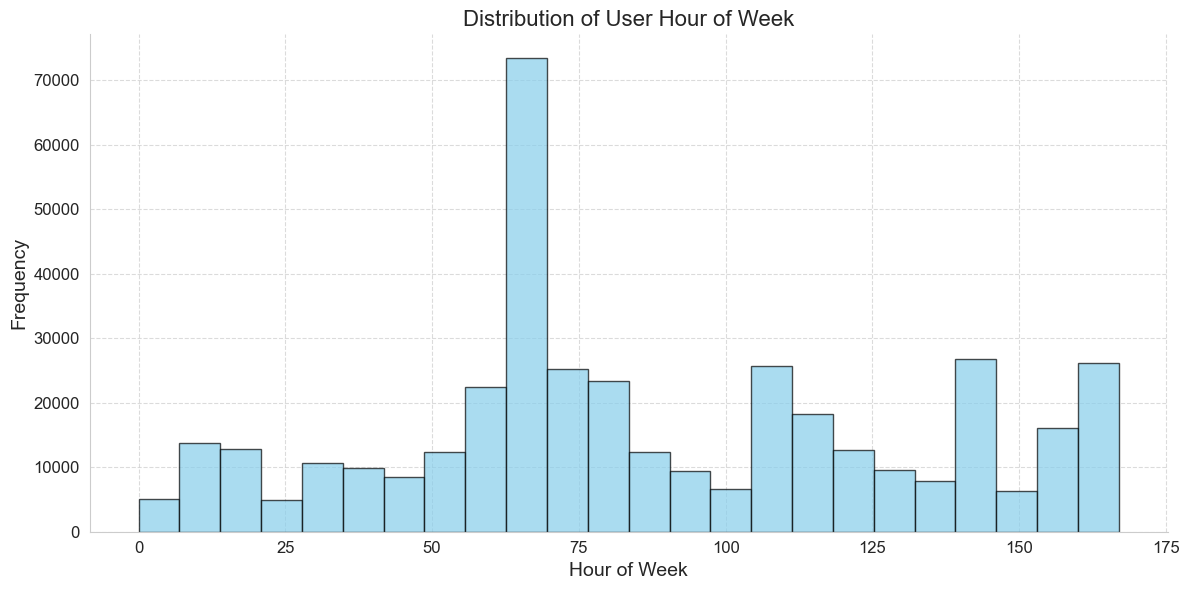

In [5]:
# Set style
sns.set_style("whitegrid")

# Plot histogram for 'USER_HOUR_OF_WEEK'
plt.figure(figsize=(12, 6))
plt.hist(data['USER_HOUR_OF_WEEK'].dropna(), bins=24, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of User Hour of Week', fontsize=16)
plt.xlabel('Hour of Week', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Remove top and right spines
sns.despine()
plt.show()

# The "frequency" in the plot refers to the number of occurrences of each hour of the week in the dataset. In the context of this histogram, 
# it represents how often users engage or interact within each specific hour throughout the week.

In [22]:
# Save plot as image
plt.savefig('hist_user_hour_of_week.png')

# Calculate descriptive statistics
desc_stats = data.describe()

# Write descriptive stats and histograms to HTML file
with open('output.html', 'w') as f:
    # Write descriptive stats
    f.write('<html>\n<body>\n')
    f.write('<h1>Descriptive Statistics</h1>\n')
    f.write(desc_stats.to_html())
    
    # Write histogram
    f.write('<h2>Distribution of User Hour of Week</h2>\n')
    f.write('<img src="hist_user_hour_of_week.png">\n')
    
    f.write('</body>\n</html>')


<Figure size 640x480 with 0 Axes>

In [6]:
# Convert specified columns to string type
float_columns = ['METRO', 'USER_HOUR_OF_WEEK']
data[float_columns] = data[float_columns].astype(str)

# Drop rows with missing values
data = data.dropna()

In [9]:
X = data.drop(columns=['Conversion']) 
y = data['Conversion']

# Specify categorical features
cat_features = ['SITE', 'AD_FORMAT', 'BROWSER_NAME', 'SUPPLY_VENDOR', 'METRO','OS_FAMILY_NAME','USER_HOUR_OF_WEEK']

# Convert numeric values in categorical features to strings
X[cat_features] = X[cat_features].astype(str)

# This is often necessary for CatBoost since it treats categorical features differently from numerical features.

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CatBoostClassifier with class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

catboost_model = CatBoostClassifier(random_state=42, class_weights=class_weights)

# Fit CatBoost model without tuning
catboost_model.fit(X_train, y_train, cat_features)

# Make predictions on test data using CatBoost without tuning
catboost_preds_default = catboost_model.predict(X_test)

# Calculate F1 score for CatBoost model without tuning
f1_default_cb = f1_score(y_test, catboost_preds_default)

print("F1 score for CatBoost model without tuning:", f1_default_cb)


Learning rate set to 0.120931
0:	learn: 0.6256275	total: 376ms	remaining: 6m 15s
1:	learn: 0.5784524	total: 746ms	remaining: 6m 12s
2:	learn: 0.5433637	total: 968ms	remaining: 5m 21s
3:	learn: 0.5152007	total: 1.24s	remaining: 5m 8s
4:	learn: 0.4931312	total: 1.41s	remaining: 4m 39s
5:	learn: 0.4775665	total: 1.55s	remaining: 4m 17s
6:	learn: 0.4643335	total: 1.72s	remaining: 4m 3s
7:	learn: 0.4536674	total: 1.85s	remaining: 3m 48s
8:	learn: 0.4451580	total: 2.09s	remaining: 3m 49s
9:	learn: 0.4385156	total: 2.31s	remaining: 3m 48s
10:	learn: 0.4320412	total: 2.67s	remaining: 3m 59s
11:	learn: 0.4270623	total: 2.89s	remaining: 3m 57s
12:	learn: 0.4240346	total: 3.08s	remaining: 3m 53s
13:	learn: 0.4189948	total: 3.41s	remaining: 4m
14:	learn: 0.4150044	total: 3.7s	remaining: 4m 3s
15:	learn: 0.4118095	total: 3.99s	remaining: 4m 5s
16:	learn: 0.4096998	total: 4.26s	remaining: 4m 6s
17:	learn: 0.4076920	total: 4.44s	remaining: 4m 2s
18:	learn: 0.4056996	total: 4.62s	remaining: 3m 58s
19:

In [7]:
# Sample the data
sampled_data = data.sample(n=100000, random_state=42)

# Define features (X) and target variable (y) for the sampled data
X_sampled = sampled_data.drop(columns=['Conversion'])
y_sampled = sampled_data['Conversion']

# Split the sampled data into train and test sets
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [9]:
# Define the hyperparameter grid for CatBoost
param_grid_catboost = {'iterations': [50, 100, 200],
                       'depth': [6, 10, 14],
                       'learning_rate': [0.01, 0.1, 1]}
                       
# Perform grid search for CatBoost
grid_search_catboost = GridSearchCV(CatBoostClassifier(random_state=42, class_weights=class_weights), param_grid_catboost, n_jobs=-1, cv=2)

grid_search_catboost.fit(X_train_sampled, y_train_sampled, cat_features=cat_features, verbose=2)

# Get the best parameters and model for CatBoost
best_params_catboost = grid_search_catboost.best_params_
best_catboost_model = grid_search_catboost.best_estimator_

print(f'best_params: {best_catboost_model}')

# Make predictions on the test data using CatBoost
catboost_preds = best_catboost_model.predict(X_test_sampled)

# Calculate F1 score for the CatBoost model tuned with GridSearchCV
f1_grid_search = f1_score(y_test_sampled, catboost_preds)

print("F1 score for CatBoost model with GridSearchCV tuning:", f1_grid_search)

0:	learn: 0.6401359	total: 1.16s	remaining: 3m 51s
2:	learn: 0.5693821	total: 3.35s	remaining: 3m 39s
4:	learn: 0.5167717	total: 4.41s	remaining: 2m 52s
6:	learn: 0.4784990	total: 6.55s	remaining: 3m
8:	learn: 0.4505538	total: 8.7s	remaining: 3m 4s
10:	learn: 0.4370735	total: 9.73s	remaining: 2m 47s
12:	learn: 0.4205084	total: 11.8s	remaining: 2m 49s
14:	learn: 0.4054090	total: 13.9s	remaining: 2m 51s
16:	learn: 0.3905953	total: 16s	remaining: 2m 51s
18:	learn: 0.3779461	total: 18.4s	remaining: 2m 55s
20:	learn: 0.3694085	total: 20.8s	remaining: 2m 57s
22:	learn: 0.3590108	total: 22.9s	remaining: 2m 56s
24:	learn: 0.3531424	total: 25.3s	remaining: 2m 56s
26:	learn: 0.3457413	total: 27.6s	remaining: 2m 56s
28:	learn: 0.3393592	total: 29.7s	remaining: 2m 55s
30:	learn: 0.3336372	total: 31.9s	remaining: 2m 53s
32:	learn: 0.3276838	total: 34.6s	remaining: 2m 55s
34:	learn: 0.3226905	total: 37.1s	remaining: 2m 54s
36:	learn: 0.3169922	total: 39.5s	remaining: 2m 53s
38:	learn: 0.3088109	tota

In [10]:
# Initialize CatBoostEncoder
catboost_encoder = CatBoostEncoder(cols=cat_features)

# Fit and transform on the training data for sampled data
X_train_encoded_sample = catboost_encoder.fit_transform(X_train_sampled, y_train_sampled)

# Transform the test data for sampled data
X_test_encoded_sample = catboost_encoder.transform(X_test_sampled)

# Fit and transform on the training data for entire dataset
X_train_encoded = catboost_encoder.fit_transform(X_train, y_train)

# Transform the test data for entire dataset
X_test_encoded = catboost_encoder.transform(X_test)

In [11]:
# Initialize RandomForestClassifier with class weights
rf_model_default = RandomForestClassifier(random_state=42, class_weight=class_weights)

# Fit the default RandomForestClassifier model
rf_model_default.fit(X_train_encoded, y_train)

# Make predictions on the test data using default RandomForestClassifier model
rf_preds_default = rf_model_default.predict(X_test_encoded)

# Calculate F1 score for the default RandomForestClassifier model
f1_default_rf = f1_score(y_test, rf_preds_default)

print("F1 score for RandomForestClassifier model without tuning:", f1_default_rf)

F1 score for RandomForestClassifier model without tuning: 0.6070728083209509


In [14]:
# Define the hyperparameter grid for RandomForestClassifier
param_grid_rf = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 5, 10],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

# Perform grid search for RandomForestClassifier with parallel processing
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight=class_weights), 
                                param_grid_rf, n_jobs=-1, cv=2)

grid_search_rf.fit(X_train_encoded_sample, y_train_sampled)

# Get the best parameters and model for RandomForestClassifier
best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

# Make predictions on the test data using RandomForestClassifier
rf_preds = best_rf_model.predict(X_test_encoded_sample)

# Calculate F1 score for the RandomForestClassifier model tuned with GridSearchCV
f1_grid_search2 = f1_score(y_test_sampled, rf_preds)

print("F1 score for RandomForestClassifier model with GridSearchCV tuning:", f1_grid_search2)


F1 score for RandomForestClassifier model with GridSearchCV tuning: 0.6089291708627057


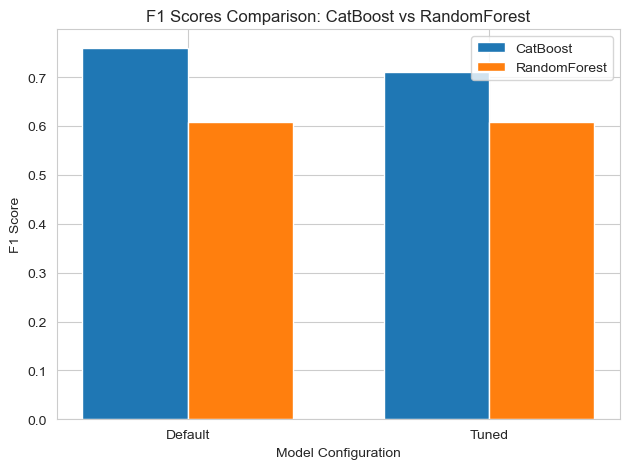

In [15]:
# F1 scores for CatBoost model
f1_scores_catboost = [0.7595, 0.7107]

# F1 scores for RandomForest model
f1_scores_rf = [0.6071, 0.6089]

# Labels for the x-axis (model configurations)
labels = ['Default', 'Tuned']

# Width of the bars
bar_width = 0.35

# Positions for the bars
x = range(len(labels))

# Plotting the bars
plt.bar(x, f1_scores_catboost, width=bar_width, label='CatBoost')
plt.bar([i + bar_width for i in x], f1_scores_rf, width=bar_width, label='RandomForest')

# Adding labels
plt.xlabel('Model Configuration')
plt.ylabel('F1 Score')
plt.title('F1 Scores Comparison: CatBoost vs RandomForest')
plt.xticks([i + bar_width/2 for i in x], labels)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
